# MSG-GAN: Multi-Scale Gradients for Generative Adversarial Networks
https://arxiv.org/pdf/1903.06048.pdf

Implementation by:

Deniz A. ACAR           denizalperacar@gmail.com 

Yavuz DURMAZKESER       yavuz.durmazkeser@metu.edu.tr 

<p style="text-align: justify">Here we present the implementation of the Multi-Scale Gradient Generative Adversarial Network (MSG-GAN) a simple but effective technique for addressing GAN training problems. This technique provides a stable approach for high resolution image synthesis, and serves as an alternative to the commonly used progressive growing technique (ProGAN [2] and StyleGAN [3]).</p>

The authors claim that `"MSG-GAN converges stably on a variety of image datasets of different sizes, resolutions and domains, as well as different types of loss functions and architectures, all with the same set of fixed hyperparameters."`

***

### Motivation

<p style="text-align: justify">Arjovsky and Bottou [4] pointed out that one of the reasons for the training instability of GANs is due to the
passage of random (uninformative) gradients from the discriminator to the generator when there is insubstantial overlap between the supports of the real and fake distributions.</p>

<p style="text-align: justify">Peng et al. [5] proposed a mutual information bottleneck between input images and the discriminator’s deepest representation of those input images called the variational discriminator bottleneck (VDB) [6], and Karras et al.[7] proposed a progressive growing technique to add continually increasing resolution layers. The VDB solution forces the discriminator to focus only on the most discerning features of the images for classification, which can be viewed as an adaptive variant of instance noise. The progressive growing technique tackles the instability problem by training the GAN layer-by-layer by gradually doubling the operating resolution of the generated images. Whenever a new layer is added to the training it is slowly faded in such that the learning of the previous layers are retained. Intuitively, this technique helps with the support overlap problem because it first achieves a good distribution match on lower resolutions, where the data dimensionality is lower, and then partially-initializes (with substantial support overlap between real and fake distributions) higher resolution training with these previously trained weights, focusing on learning finer details.
</p>
<p style="text-align: justify">
While this approach is able to generate state-of-the-art results, it can be hard to train, due to the addition of hyperparameters to be tuned per resolution, including different iteration counts, learning rates (which can be different for the Generator and Discriminator [8]) and the fade-in iterations. In addition, a concurrent submission [9] discovered that it leads to phase artifacts where certain generated features are attached to specific spatial locations. Hence the main motivation in this paper lies in addressing these problems by providing a simpler alternative that leads to high quality results and stable training.
</p>



The idea behind MSG-GAN is presented below:

<img src="doc/schematic_1.png">

Architecture of MSG-GAN, shown here on the base model proposed in ProGANs which is implemented in this project.

***

### Multi-Scale Gradient GAN

#### Generator Architecture
***
Let the initial block of the generator function $g_{gen} = A_{begin}$ where $A_{begin} \in \mathbb{R}^{4 \times4\times512}$ contains [4x4x512] dimensional activations. Let $g^i$ be a generic function which acts as the basic generator block where in this implementation consists of an upsampling operation followed by two conv layers.

<img src="doc/generator_eqn.png" style="width: 450px;">

where $c_i$ is the number of channels in the $i^{th}$ intermediate activations of the generator. The full generator is as follows:

<img src="doc/full_generator.png" style="width: 400px;">

Where $z~\mathcal{N}(0, \mathbb{I})$.

The generator architecture is presented below:

<img src="doc/generator_schema.png" style="width: 300px;">

***

##### Generator output for different stages

The r is defined such that it generates the output RGB at different stages of the generator where its output corresponds to different downsampled versions of the final output image. It is simply a $(1\times1)$ convolution which converts the intermediate convolutional activation volume into images.

<img src="doc/toRGB.png" style="width: 500px;">

In other words, $o_i$ is an image synthesized from the output of the $i^{th}$ intermediate layer of the generator $a_i$ similar to the idea behind progressive growing.

***

#### Discriminator Architecture

Because the discriminator’s final critic loss is a function of not only the final output of the generator y', but also the intermediate outputs $o_i$, gradients can flow from the intermediate layersof the discriminator to the intermediate layers of the generator.

Here all components of the the discriminator are denoted by `"d"`. 
The final layer of the discriminator is called $d_{critic}(z')$ and the function which defines the first layer of the discriminator is denoted by $d^0(y)$ or $d^0(y)$ taking the real image y (true sample) or the highest resolution synthesized image y' (fake sample) as the input. 

Similarly, let $d^j$ represent the intermediate layer function of the discriminator. Note that i and j are always related to each other as j = k−i. Thus, the output activation volume $a'_j$ of any $j^{th}$ intermediate layer of the discriminator is defined as:

<img src="doc/disc_eqn.png" style="width: 450px;">

where $\phi$ is a function used to combine the output oi of the $i^{th}$ intermediate layer of the generator (or correspondingly downsampled version of the highest resolution real image y) with the corresponding output of the (j − 1)th intermediate layer in the discriminator.

There are three different varients of the $\phi$ which are as follows:

<img src="doc/phi.png" style="width: 400px;">

where, r' is yet another (1x1) convolution operation similar to r and [;] is a simple channelwise concatenation operation.

The full discriminator is as follows:

<img src="doc/discriminator_full.png" style="width: 700px;">

The discriminator architecture is represented below:

<img src="doc/disc_architecture.png">

***

#### Loss Function

They used two different loss functions for the $d_{critic}$ function namely, WGAN-GP [10] which wasused by ProGAN [2] and Non-saturating GAN loss with 1-sided GP [11] which was used by StyleGAN [3]. `One thing to note that is the fact that the discriminator is now a function of multiple input images generated by the generator, thus gradient penalty is modified to be the average of the penalties over each input.`
    
<img src="doc/wgangp.png" style="width: 700px;">

***
### Implementation Notes

There two different architectures discussed in the paper in accordance with the technique presented here. We have selected ProGANs based architecture to implement for the course project which was also in accordance with our selected qualitative and quantitative results. We have consulted with the instructor of the course and decided to focus on the aforementioned architecture. As the loss function of ProGANs is WGAN-GP is implemented here.    


# Hyper-parameters

In [1]:
num_epochs = 1 # we only train for a single epoch in this notebook
lr = 0.0001
batch_size = 16
latent_dim = 128
num_blocks = 4
use_gpu = 1
n_disc = 1 # the number of discriminator iterations per generator iteration
dataset = "CIFAR10"
wgan_lambda = 10.
# channels = np.array([512,512,512,512,512,256,128,64,32,16]).astype(int)//4 # channel sizes

# Training a Model

#### Beware
Training would modify the pretrained models as the RMSPROP's learning rate at the start would be higher than the one that is used during training so you might get slightly changed results. So we have provided another directory for saving the test run of the model in /test.
We let the model run for one epoch which is shown below.

In [3]:
!python train.py --save_dir test/ --continue_checkpoint 1 --num_epochs 1 --lr 0.0001 --batch_size 16 --latent_dim 128 --num_blocks 4 --use_gpu 1 --n_disc 1 --dataset CIFAR10 --lamda 10.0 

Files already downloaded and verified
Files already downloaded and verified
iterations 00100 discriminator loss stats|mean      38.56839752 |min      38.56839752 | max      38.56839752 | std       0.00000000 |time       8.53943443s
iterations 00200 discriminator loss stats|mean      41.11205212 |min     -51.84790802 | max     909.84814453 | std      91.55931288 |time       8.73256826s
iterations 00300 discriminator loss stats|mean      31.33119329 |min      13.34284210 | max     113.54114532 | std      14.44094892 |time       8.06022549s
iterations 00400 discriminator loss stats|mean      15.74833590 |min       7.43544960 | max      65.26341248 | std       5.96791114 |time       8.73481011s
iterations 00500 discriminator loss stats|mean       1.13951296 |min     -14.98306561 | max      16.95270157 | std       6.84962531 |time       8.04238391s
iterations 00600 discriminator loss stats|mean     -14.85713659 |min     -25.12168503 | max      66.69549561 | std      11.73025466 |time       

# Quantitative Results

We aimed to reproduce the results in Table 3, which is in page 8, of the paper, as quantitative results. Results published by the authors are given in the figure below.

<img src="doc/table3.png" style="width: 400px;">

## Testing Inception Score Implementation

In [2]:
from src.inception_score import Inception_Score
from src.data_loader import DataLoader
import torch

# load real cifar10 images
cifar_dataloader = DataLoader("CIFAR10", batch_size=60000, num_blocks=4, device='cuda')
cifar_images = cifar_dataloader.load_images()[3]

# initialize inception scorer
IS = Inception_Score('cuda')

# compute inception score
real_images_std, real_images_mean = IS(cifar_images)

print("Inception Score of Real CIFAR10 Images (Results in First Row of Table 3): ")
print("\tmean=%.2f, std=%.2f" % (real_images_mean, real_images_std))

Files already downloaded and verified
Files already downloaded and verified
Inception Score of Real CIFAR10 Images (Results in First Row of Table 3): 
	mean=9.45, std=0.10


## Inception Scores of Our Model 1. Learning rate 0.0001

In [72]:
from src import model
from src.custom import get_latent_variable
import numpy as np
device = torch.device("cuda:0")
# load pretrained generator
num_blocks = 4
latent_dim = 512
batch_size = 256 
channels = np.array([512*4,512,512,512,512,256,128,64,32,16]).astype(int)//4
generator = model.Generator(
    num_blocks,
    channels=channels
    ).to(device)
# pretrained weights are available in the following folder
generator = torch.load('weights/CIFAR10/generator')

# generate fake images
cifar_fake_images = torch.zeros((50000, 3, 32, 32))
with torch.no_grad():
    for idx in range(0, 50000, batch_size):
        latent_variable = get_latent_variable(min(batch_size, 50000 - idx), latent_dim, device)
        cifar_fake_images[idx:idx+batch_size] = generator(latent_variable)[num_blocks-1]

# compute inception score
fake_images_std, fake_images_mean = IS(cifar_fake_images)

print("Inception Score of Generated CIFAR10 Images: ")
print("\tmean=%.2f, std=%.2f" % (fake_images_mean, fake_images_std))

Inception Score of Generated CIFAR10 Images: 
	mean=5.58, std=0.08


## Inception Scores of Our Model 2. Learning rate 0.00005

In [73]:
from src import model
from src.custom import get_latent_variable
import numpy as np
device = torch.device("cuda:0")
# load pretrained generator
num_blocks = 4
latent_dim = 512
batch_size = 256 
channels = np.array([512*4,512,512,512,512,256,128,64,32,16]).astype(int)//4
generator = model.Generator(
    num_blocks,
    channels=channels
    ).to(device)
# pretrained weights are available in the following folder
generator = torch.load('weights/CIFAR10_2/generator')

# generate fake images
cifar_fake_images = torch.zeros((50000, 3, 32, 32))
with torch.no_grad():
    for idx in range(0, 50000, batch_size):
        latent_variable = get_latent_variable(min(batch_size, 50000 - idx), latent_dim, device)
        cifar_fake_images[idx:idx+batch_size] = generator(latent_variable)[num_blocks-1]

# compute inception score
fake_images_std, fake_images_mean = IS(cifar_fake_images)

print("Inception Score of Generated CIFAR10 Images: ")
print("\tmean=%.2f, std=%.2f" % (fake_images_mean, fake_images_std))

Inception Score of Generated CIFAR10 Images: 
	mean=5.53, std=0.07


Due to time limitations we had to stop the training of the models early (although we got satisfying results).

Also as specified in the difficulties section we might not get close values for IS score to that presented in the paper due to the fact that our IS score is way lower than the reference presented in the paper for the real images.

<img src="doc/pp.jpeg" style="width: 700px;">

# Qualitative Results

The model can be loaded as follows:

In [4]:
from src import model
from src.custom import get_latent_variable
from torchvision.utils import save_image
import matplotlib.image as mpimg 
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]

device = torch.device("cuda:0")

# CelebA Results

In [80]:
num_blocks = 6
latent_dim = 128
batch_size = 256
channels = np.array([512,512,512,512,512,256,128,64,32,16]).astype(int)//4
generator = model.Generator(
    num_blocks,
    channels=channels
    ).to(device)
# pretrained weights are available in the following folder
generator = torch.load('weights/CelebA/generator')

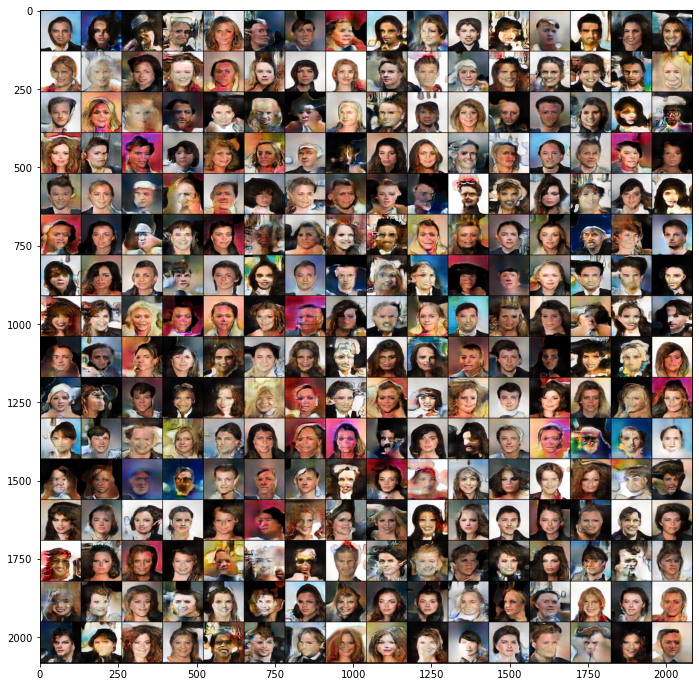

In [82]:
latent_variable = get_latent_variable(batch_size, latent_dim, device)
fake_images = generator(latent_variable)[num_blocks-1].detach().to('cpu')
save_image(
    fake_images.data[:batch_size], 
    "doc/qualitative_CelebA_result.png", 
    nrow=int(batch_size**0.5), 
    value_range=(-1,1), 
    normalize=True)
img = mpimg.imread("doc/qualitative_CelebA_result.png") 
plt.imshow(img) 

### Paper CelebA Qualitative Results

<img src="doc/celeba.png" style="width: 400px;">

# CIFAR 10 Results

In [5]:
num_blocks = 4
latent_dim = 512
batch_size = 256 
channels = np.array([512*4,512,512,512,512,256,128,64,32,16]).astype(int)//4
generator = model.Generator(
    num_blocks,
    channels=channels
    ).to(device)
# pretrained weights are available in the following folder
generator = torch.load('weights/CIFAR10/generator')

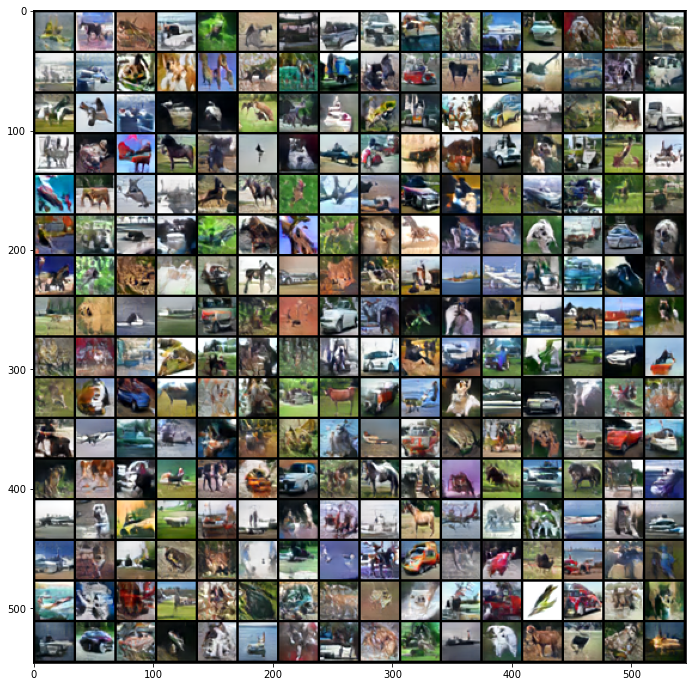

In [7]:
latent_variable = get_latent_variable(batch_size, latent_dim, device)
fake_images = generator(latent_variable)[num_blocks-1].detach().to('cpu')
l = 256
save_image(
    fake_images.data[:batch_size], 
    "doc/qualitative_CIFAR10_result.png", 
    nrow=int(batch_size**0.5), 
    value_range=(-1,1), 
    normalize=True)
img = mpimg.imread("doc/qualitative_CIFAR10_result.png") 
plt.imshow(img) 

### CIFAR10 Qualitative Results

<img src="doc/cifar.png" style="width: 600px;">

# Difficulties 



- Specified learning rates caused the model loss to diverge. We suspect they could train the model via large learning rates with large batch sizes
***
- In order to have a reasonable training time and due to memory limitations we have downsized the model by factor 4 in channel sizes and latent dimension for training. Although the users of the code can use the full sized model as well for the training. 

***
- We have obtained lower values for inception score in the real CIFAR 10 images (9.45) compared to the results that authors have used (11.39). Our results match the ones presented in [12] obtained using pytorch therefore we think that the difference observed is due to utilization of pytorch. As a result we expect lower values compared to the ones obtained presented in the paper.

# References

1.  https://arxiv.org/pdf/1903.06048.pdf
2.  https://arxiv.org/pdf/1710.10196.pdf
3.  https://arxiv.org/pdf/1812.04948.pdf
4.  https://arxiv.org/pdf/1701.04862.pdf
5.  https://arxiv.org/pdf/1810.00821.pdf
6.  https://arxiv.org/pdf/1810.00821.pdf
7.  https://arxiv.org/pdf/1710.10196.pdf 
8.  https://arxiv.org/pdf/1706.08500.pdf
9.  https://arxiv.org/pdf/1912.04958.pdf
10. https://arxiv.org/pdf/1704.00028.pdf
11. https://arxiv.org/pdf/1801.04406.pdf
12. https://arxiv.org/pdf/1801.01973.pdf